In [ ]:
import os
#no using upsampling
train_dir = 'Processed_ImTr'   # Training set(preprocessed)
test_dir = 'Processed_Te'    # Test set

In [ ]:
# 각 폴더에 있는 이미지 데이터 갯수 출력
train_class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in os.listdir(train_dir)}
test_class_counts = {class_name: len(os.listdir(os.path.join(test_dir, class_name))) for class_name in os.listdir(test_dir)}

print("Training dataset class counts:")
print(train_class_counts)

print("\nTesting dataset class counts:")
print(test_class_counts)

Training dataset class counts:
{'glioma': 1020, 'meningioma': 677, 'notumor': 539, 'pituitary': 250}

Testing dataset class counts:
{'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import cv2

# 이미지 로드 함수
def load_images_from_folder(folder, size=(224, 224)):
    images = []
    labels = []
    for class_idx, class_name in enumerate(os.listdir(folder)):
        class_folder = os.path.join(folder, class_name)
        for filename in os.listdir(class_folder):
            img = cv2.imread(os.path.join(class_folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
                images.append(np.stack([img_resized] * 3, axis=-1))  # 3채널로 변환
                labels.append(class_idx)
    return np.array(images), np.array(labels)

In [ ]:
# training 데이터 불러오기
X_train, y_train = load_images_from_folder(train_dir)
# glioma : 0, meningioma : 1, notumor : 2, pituitary : 3

# training set:validation set = 8:2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}, Validation set size: {X_val.shape[0]}")

Training set size: 1988, Validation set size: 498


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# EfficientNetB0 기반 CNN 모델 정의
def build_model(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # False : pretrained model의 가중치 변경 없이 사용, True : 가중치 변경

    model = Sequential([
        # 특징 추출을 위환 efficientNetB0
        base_model,
        # 데이터 크기를 줄이기 위해 flatten 대신 사용
        GlobalAveragePooling2D(),
        # overfitting을 방지하기 위한 dropout
        Dropout(0.5),
        # ReLU : 은닉층에서 사용, Gradient 소실 문제 감소
        # full connected layer, 128개의 뉴런
        Dense(128, activation='relu'),
        # 4개의 클래스 분류, Softmax : 다중 클래스 분류를 위해 사용
        Dense(num_classes, activation='softmax')
    ])

    # Adam(Apaptive Moment Estimation)경사 하강법으로 가중치 업데이트
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    base_model.summary() # efficientNetB0 구조
    return model

In [ ]:
model = build_model(num_classes=4) # 4개의 클래스를 분류

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_60 (InputLayer)   │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_54 (Rescaling)      │ (None, 224, 224, 3)       │               0 │ input_layer_60[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_27              │ (None, 224, 224, 3)       │               7 │ rescaling_54[0][0]         │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_55 (Rescaling)      │ (None, 224, 224, 3)       │               0 │ normalization_27[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_55[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             28

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_30          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
import matplotlib.pyplot as plt
import time

In [ ]:
start = time.time() #시작 시간
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
end = time.time() # 종료 시간

execution_time = end - start # execution time 계산
print(f"total Training time: {execution_time:.2f} seconds")

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 726ms/step - accuracy: 0.5983 - loss: 0.8817 - val_accuracy: 0.8695 - val_loss: 0.3206
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 708ms/step - accuracy: 0.8522 - loss: 0.3889 - val_accuracy: 0.8916 - val_loss: 0.2733
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 706ms/step - accuracy: 0.8649 - loss: 0.3370 - val_accuracy: 0.8775 - val_loss: 0.2667
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 712ms/step - accuracy: 0.8683 - loss: 0.3182 - val_accuracy: 0.8916 - val_loss: 0.2554
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 714ms/step - accuracy: 0.8871 - loss: 0.2639 - val_accuracy: 0.9016 - val_loss: 0.2184
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 710ms/step - accuracy: 0.8830 - loss: 0.2790 - val_accuracy: 0.9157 - val_loss: 0.2152
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 709ms/step - accuracy: 0.8907 - loss: 0.2744 - val_accuracy: 0.8936 - val_loss: 0.2159
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8901 - loss: 0.2464 - val_accurac

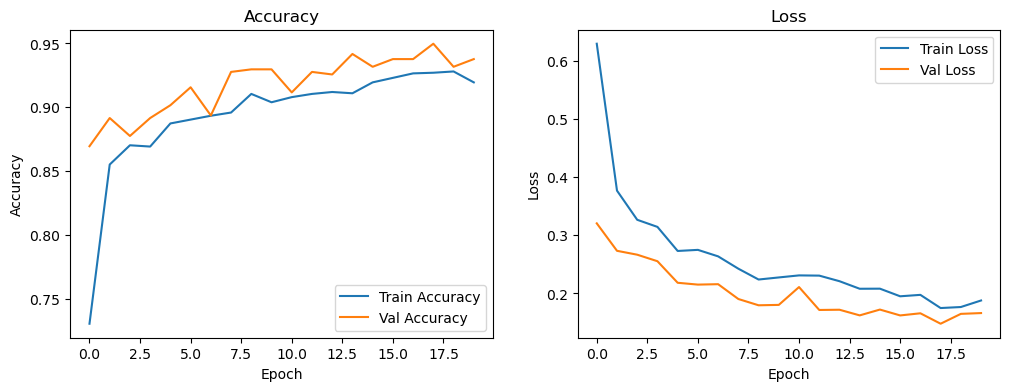

In [ ]:

# Accuracy와 Loss 그래프 출력
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

class_labels = [class_name for class_name in os.listdir(train_dir)]

# 테스트 데이터 로드
X_test, y_test = load_image_from_folder(test_dir)

# 테스트
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 595ms/step


In [ ]:
# test 정확도 출력
test_accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 78.79%


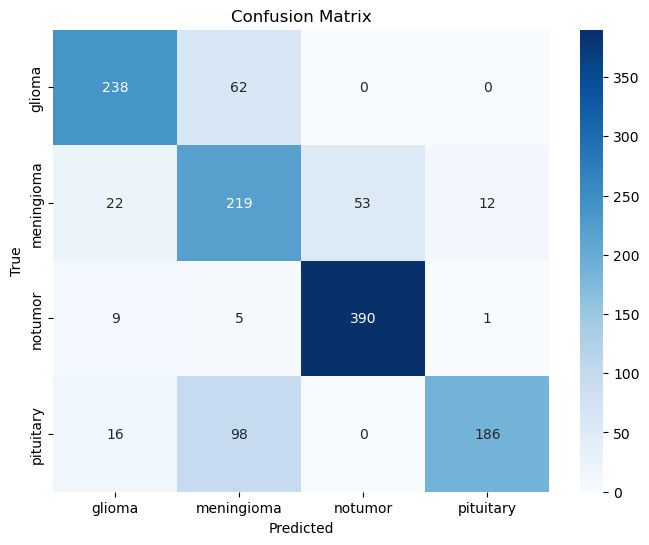

In [ ]:
# 혼돈 행렬 출력
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()